# Final Project Submission

- Student name: Sabina Bains
- Student pace: Self Paced
- Scheduled project review date / time: XXX
- Instructor name: Claude Fried

# Summary

Add Summary here


data - https://www.kaggle.com/code/anayad/classifying-cyberbullying-tweets/data


# Business Understanding

# Data Understanding

#### Reading in Necessary Packages

In [73]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.metrics import plot_confusion_matrix
from nltk.util import ngrams

import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')

COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [74]:
# Split then vectorize (correct way)
# We do the train/test split before the CountVectorizer to properly simulate the real world where our future data contains words we have not seen before

#### Reading in Data

In [75]:
df = pd.read_csv('data/cyberbullying_tweets.csv')


# replacing offensive words
df.tweet_text = df.tweet_text.str.replace('ggers','nnnn')
df.tweet_text = df.tweet_text.str.replace('gger','nnnn')

#### Understanding Labels

In [76]:
# checking distribution of target values - looks like a balanced dataset
pd.DataFrame(df.cyberbullying_type.value_counts(normalize=True))

,cyberbullying_type
religion,0.167701
age,0.167575
gender,0.167177
ethnicity,0.166925
not_cyberbullying,0.166590
other_cyberbullying,0.164032


In [77]:
# standardizing words to all be lowercase
def lowercase(x):
    return x.lower()

df.tweet_text = df.tweet_text.apply(lowercase)

In [78]:
# tokenizing words in df to inspect differences in cyberbullying classes
def tokenize(x):
    token_pattern = r"(?u)\b\w\w+\b"
    tokenizer = RegexpTokenizer(token_pattern)
    return tokenizer.tokenize(x)

df['tokens'] = df.tweet_text.apply(tokenize)

In [79]:
# removing stopwords from data
stopwords_list = stopwords.words('english')

def remove_stopwords(token_list):
    return [word for word in token_list if word not in stopwords_list]

df.tokens = df.tokens.apply(remove_stopwords)

FreqDist(df.tokens.explode()).most_common(30)[22:25]

[('mkr', 2543), ('muslims', 2513), ('muslim', 2491)]

In [80]:
# Above we can see we need to stem the data (muslim vs. muslims)
stemmer = SnowballStemmer(language="english")

def stem(tweets):
    return [stemmer.stem(tweet) for tweet in tweets]

df.tokens = df.tokens.apply(stem)

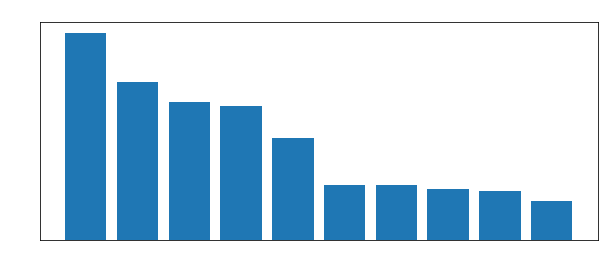

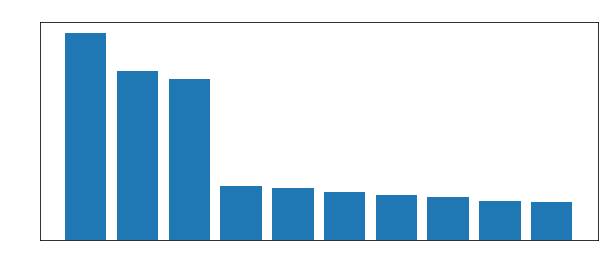

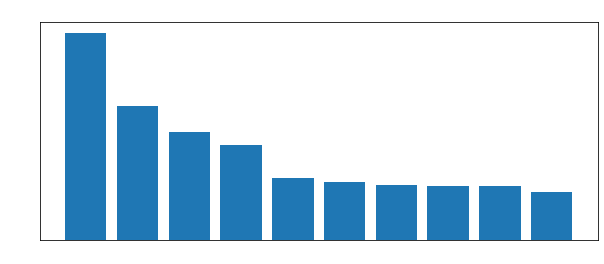

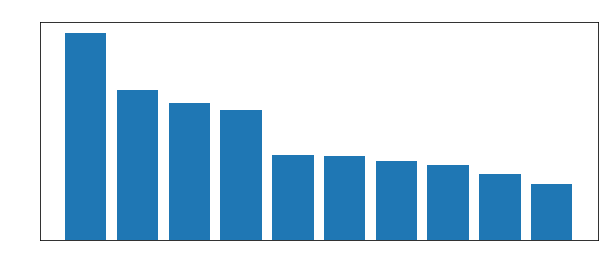

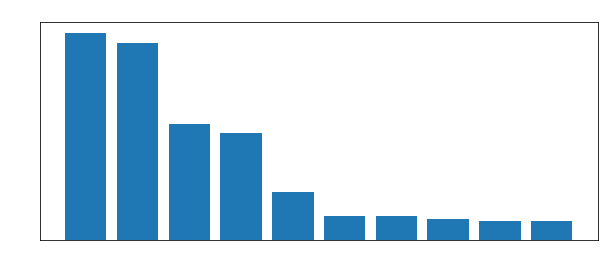

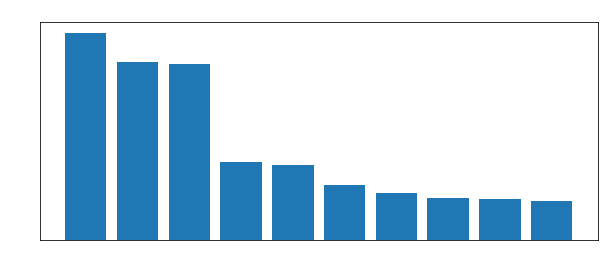

In [81]:
# Creating frequency distributions for each label to visually inspect most common words in each tag
freq_dict = {}

for target in df.cyberbullying_type.unique():
    freq_dict[target] = FreqDist(df.loc[df.cyberbullying_type == target].tokens.explode())
    
    top_10 = list(zip(*freq_dict[target].most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    fig = plt.figure(figsize=(10,4))
    plt.bar(tokens,counts)
    plt.title('Top tokens for '+target)
    plt.show()

#### Splitting Tweets and Labels into two dataframes

In [19]:
X = pd.DataFrame(df.tweet_text)
y = df.cyberbullying_type

#### Performing Train Test Split for Data Validation

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [23]:
# plot_confusion_matrix(baseline_model, X_train, df['cyberbullying_type']);

## creating bigrams

In [24]:
def bigram(tweet):
    return [' '.join(word) for word in ngrams(tweet, 2)]

def _3gram(tweet):
    return [' '.join(word) for word in ngrams(tweet, 3)]

df['bigram'] = df.tokens.apply(bigram)
df['_3gram'] = df.tokens.apply(_3gram)

In [25]:
FreqDist(df.bigram.explode()).most_common(10)

[('high school', 4733),
 ('http co', 2392),
 ('rape joke', 2291),
 ('dumb ass', 1570),
 ('bulli high', 1549),
 ('school bulli', 1502),
 ('girl bulli', 1449),
 ('ass ninnnn', 1272),
 ('dumb fuck', 1158),
 ('dumb ninnnn', 1061)]

In [26]:
# from sklearn.pipeline import Pipeline
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# from sklearn.model_selection import train_test_split, GridSearchCV
# text_clf = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer()),
#                      ('clf', MultinomialNB())])
# tuned_parameters = {
#     'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
#     'tfidf__use_idf': (True, False),
#     'tfidf__norm': ('l1', 'l2'),
#     'clf__alpha': [1, 1e-1, 1e-2]
# }

# MODELING

#### Baseline Model

In [16]:
# initializing basic TFIDF vectorizer with 50 words with highest tfidf values
tfidf = TfidfVectorizer(max_features=50)

# Vectorizing tweets for modeling
X_train_v = tfidf.fit_transform(X_train.tweet_text)

# viewing features
pd.DataFrame.sparse.from_spmatrix(X_train_v, columns=tfidf.get_feature_names()).head(1)

,about,all,and,are,as,at,be,bullied,bully,but,...,they,this,to,was,we,what,who,with,you,your
0,0.0,0.0,0.270936,0.0,0.0,0.462374,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
# Instantiating a MultinomialNB classifier
model_1 = MultinomialNB()

# Running baseline model


score_1 = cross_val_score(model_1, X_train_v, y_train).mean()
print('Accuracy: {:.1%}'.format(score_1))
print('''\nOur baseline model performs relatively well, if we were to randomly classify cyberbullying we would get an accuracy of 16.6%, whereas our model has an
accuracy of over 3x better. However this model will still predict correctly only about half the time. Let's try to improve it by removing stopwords.''')

Accuracy: 56.1%

Our baseline model performs relatively well, if we were to randomly classify cyberbullying we would get an accuracy of 16.6%, whereas our model has an
accuracy of over 3x better. However this model will still predict correctly only about half the time. Let's try to improve it by removing stopwords.


#### Model #2 - removing stopwords

In [18]:
stopwords_list = stopwords.words('english')

In [19]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features=50,
    stop_words=stopwords_list
)

# Fit and transform X_train
X_train_v = tfidf.fit_transform(X_train.tweet_text)

# look at data
pd.DataFrame.sparse.from_spmatrix(X_train_v, columns=tfidf.get_feature_names()).head(1)

,amp,ass,bitch,black,bullied,bullies,bully,call,called,christian,...,school,see,shit,think,time,ur,white,woman,women,would
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_score = cross_val_score(baseline_model, X_train_v, y_train).mean()
print('Accuracy: {:.1%}'.format(baseline_score))

Accuracy: 64.2%


#### Model #4 - Removed Stopwords and Stemmed

In [21]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features = 50,
    stop_words = stopwords_list,
    token_pattern = r"(?u)\b\w+\b" #Changing tokens to include single letter words since people on twitter type in shorthand
)

# Fit the vectorizer on col and transform it
X_vector = tfidf.fit_transform(df["tweet_text"])

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_vector, columns=tfidf.get_feature_names()).head()

,amp,ass,bitch,black,bullied,bullies,bully,call,called,christian,...,school,see,shit,think,u,ur,white,woman,women,would
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.727968,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [22]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_score = cross_val_score(baseline_model, X_train_v, y_train).mean()
print('Accuracy: {:.1%}'.format(baseline_score))

Accuracy: 64.2%


#### Model #4 - Removed Stopwords and added Bigrams

In [23]:
# Instantiate the vectorizer
tfidf = TfidfVectorizer(
    max_features = 80,
    stop_words = stopwords_list,
    token_pattern = r"(?u)\b\w+\b",
    ngram_range = (1, 2)
)

# Fit the vectorizer on col and transform it
X_train_v = tfidf.fit_transform(X_train.tweet_text)

# Visually inspect the vectorized data
pd.DataFrame.sparse.from_spmatrix(X_train_v, columns=tfidf.get_feature_names()).head(1)

,also,amp,anything,ass,ass ninnnn,back,bitch,black,bullied,bullied high,...,think,time,u,ur,us,want,white,woman,women,would
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_score = cross_val_score(baseline_model, X_train_v, y_train).mean()
print('Accuracy: {:.1%}'.format(baseline_score))

Accuracy: 69.3%


#### NEW MODEL - adding has_link feature and is_reply

In [25]:
# creating a column that notes if a tweet has a link or not
def has_link(x):
    if 'https' in x:
        return 1
    else:
        return 0

X_train['has_link'] = X_train.tweet_text.apply(has_link)

In [26]:
# creating a column that notes if a tweet is a reply or not
def is_reply(x):
    if '@' in x:
        return 1    
    else:
        return 0

X_train['is_reply'] = df.tweet_text.apply(is_reply)

In [27]:
# resetting indices
X_train.reset_index(inplace=True)

In [28]:
# creating a column that notes if a tweet has an emoticon or not
emoticon_query = r'(?:[\:;X=B][-^]?[)\]3D([OP/\\|])(?:(?=\s))'
X_train["has_emoticon"] = X_train.tweet_text.str.contains(emoticon_query)

In [29]:
# adding new columns to dataframe

X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_v, columns=tfidf.get_feature_names())
X_train_2 = pd.concat([X_train_df, X_train[['has_link', 'is_reply', 'has_emoticon']]], axis=1)
X_train_2.head(1)

,also,amp,anything,ass,ass ninnnn,back,bitch,black,bullied,bullied high,...,ur,us,want,white,woman,women,would,has_link,is_reply,has_emoticon
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,False


In [30]:
# Instantiate a MultinomialNB classifier
baseline_model = MultinomialNB()

# Evaluate the classifier on X_train_vectorized and y_train
baseline_score = cross_val_score(baseline_model, X_train_2, y_train).mean()
print('Accuracy: {:.1%}'.format(baseline_score))

Accuracy: 72.7%


In [32]:
#### TRYING TENSORFLOW AND KERAS
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
import numpy as np

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [44]:
data = df['tweet_text'].map(word_tokenize).values
total_vocabulary = set(word.lower() for tweet in data for word in tweet)  # set created from nested comprehension 

In [68]:
# import numpy as np
# from tensorflow import keras
# from keras_preprocessing.text import Tokenizer
# tokenizer = Tokenizer(char_level=True)
# print('total number of tweets: ', len(df.tweet_text))
# # create mapping of unique chars to integers and reverse
# tokenizer.fit_on_texts(df.tweet_text)
# char_index = tokenizer.word_index
# print('Found %s unique characters. ' % len(char_index))
# print('char to integer dictionary: ',char_index)
# index_char = dict(enumerate(char_index.keys()))
# print('integer to char dictionary: ',index_char)

total number of characters in book:  47692
Found 757 unique characters. 
char to integer dictionary:  {' ': 1, 'e': 2, 't': 3, 'a': 4, 'o': 5, 'i': 6, 'n': 7, 's': 8, 'r': 9, 'h': 10, 'l': 11, 'u': 12, 'd': 13, 'm': 14, 'c': 15, 'y': 16, 'g': 17, 'b': 18, 'w': 19, 'p': 20, 'f': 21, '.': 22, 'k': 23, 'v': 24, ',': 25, '@': 26, "'": 27, 'j': 28, '/': 29, ':': 30, '!': 31, '#': 32, '?': 33, 'x': 34, '’': 35, '"': 36, 'z': 37, '-': 38, '1': 39, '_': 40, '0': 41, 'q': 42, '2': 43, ';': 44, '&': 45, '3': 46, '4': 47, '5': 48, '9': 49, '“': 50, '”': 51, '8': 52, ')': 53, '7': 54, '6': 55, '(': 56, '*': 57, '…': 58, '\x9f': 59, 'ð': 60, '=': 61, 'â': 62, '%': 63, '\x98': 64, '+': 65, '—': 66, '\r': 67, '\n': 68, '‘': 69, 'é': 70, '\x80': 71, 'ã': 72, '\x82': 73, '$': 74, '~': 75, '¦': 76, ']': 77, '^': 78, '[': 79, '¤': 80, '\x8f': 81, '|': 82, '•': 83, '°': 84, '️': 85, '\x99': 86, 'ç': 87, '›': 88, '>': 89, 'í': 90, '\x8d': 91, '❤': 92, 'á': 93, '😂': 94, '\x92': 95, '\x94': 96, 'ó': 97, '\\'

In [66]:
# use one hot encoding since our target is categorical
y_train_d = pd.get_dummies(y_train).values

# use keras to create a Tokenizer object
tokenizer = text.Tokenizer(num_words=20000)  # limit to the num_words most important ones

# tokenizer.fit_on_texts(list(X_train))
# tokenized_texts = tokenizer.texts_to_sequences(X_train)
# X_train_pad = sequence.pad_sequences(tokenized_texts, maxlen=100)

X_train_pad = pad_sequences(X_train, maxlen=140)

ValueError: invalid literal for int() with base 10: 'tweet_text'

In [53]:
# create my NN model
model = Sequential()

embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))  # use 4 because we have 4 categories

In [54]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary() # check the shape=

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         8440832   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)               

In [56]:
X_train

,tweet_text
32253,these are the type of bitches who used to bull...
45039,fuck around and get smoked rt @dizure_: type t...
13889,"deprived of new women to hate in toronto, a vo..."
19701,even you know your position on mic. cool down ...
35249,"the first time i was in middle school, i was a..."
...,...
34686,i’ve known a girl when i was in high school wh...
45684,"rt""@tayyoung_: fuck obama, dumb ass ninnnn"" wh..."
18221,wrong! i love muslims but not radical islam an...
27718,@shervyn i need to be less uncomfortable talki...


In [57]:
model.fit(X_train_pad, y_train_d, epochs=10, batch_size=32, validation_split=0.1)

ValueError: Training data contains 1 samples, which is not sufficient to split it into a validation and training set as specified by `validation_split=0.1`. Either provide more data, or a different value for the `validation_split` argument.

In [5]:
# glove = {}
# with open('glove.6B.50d.txt', 'rb') as f:
#     for line in f:
#         parts = line.split()
#         word = parts[0].decode('utf-8')
#         if word in total_vocabulary:
#             vector = np.array(parts[1:], dtype=np.float32)
#             glove[word] = vector

In [ ]:
model_1 = Sequential()
model_1.add(tf.keras.layers.Embedding(word_size, embed_size, input_shape=(x_train.shape[1],)))
# LSTM Layer
model_1.add(tf.keras.layers.LSTM(units=128, activation='tanh'))
# Output Layer
model_1.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [86]:
dictionary = FreqDist(df.tokens.explode()).most_common(20000)

In [87]:
len(dictionary)

20000

In [98]:
all_tokens_list = list(itertools.chain.from_iterable(df.tokens))
all_tokens_set = set(all_tokens_list)
token_freqs = {token : 0 for token in all_tokens_set}

for token in all_tokens_list:
    token_freqs[token] += 1
    
top_10000 = sorted(token_freqs.items(), key=lambda x: x[1], reverse=True)[:10000]
top_10000_dict = {x[0] : idx for idx, x in enumerate(top_10000)}

In [99]:
numberize = {}
for token in all_tokens_set:
    if token in top_10000_dict.keys():
        numberize[token] = top_10000_dict[token]
    else:
        numberize[token] = 10000
        
reverse_numberize = {10000 : '<UNK>', 10001: '<EOS>'}
for token, idx in top_10000_dict.items():
    reverse_numberize[idx] = token

In [113]:
# Create numberized sentences, end-padded with <EOS> tokens to length 30.
# Filters for sentences of length <30.
numberized_sents = [
  [numberize[token] for token in df.tweet_text] + [10001]*(30 - len(df.tweet_text))
  for token in df.tweet_text
  if len(df.tweet_text) < 30
]

In [119]:
[numberize[token] for token in df.tweet_text]

KeyError: 'in other words #katandandre, your food was crapilicious! #mkr'

## Links

https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e

data - https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification

https://www.ritchieng.com/machine-learning-multinomial-naive-bayes-vectorization/

https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

looking at diff models - https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f



In [120]:
from keras.datasets import imdb
import pandas as pd
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

In [131]:
data = pd.read_csv('/Users/sabinabains/Downloads/IMDB Dataset.csv')
data['review'] = data['review'].str.lower()

In [134]:
def remove_stopwords(data):
  data['review without stopwords'] = data['review'].apply(lambda x : ' '.join([word for word in x.split() if word not in (stopwords_list)]))
  return data

In [135]:
data = remove_stopwords(data)

In [139]:
# reviews_list = []
# for i in range(len(reviews)):
#     reviews_list.append(reviews[i])
 
# sentiment = data_without_stopwords['sentiment']

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [140]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

In [141]:
word_to_vec_map = read_glove_vector('/Users/sabinabains/Downloads/glove.6B.50d.txt')
maxLen = 150

In [ ]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [153]:
data.head()

,review,sentiment,review without stopwords
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching 1 oz episode ...
1,a wonderful little production. <br /><br />the...,positive,wonderful little production. <br /><br />the f...
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,basically there's a family where a little boy ...,negative,basically there's family little boy (jake) thi...
4,"petter mattei's ""love in the time of money"" is...",positive,"petter mattei's ""love time money"" visually stu..."


In [164]:
X_train_indices = tokenizer.texts_to_sequences(data['review without stopwords'])

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')

In [165]:
len(X_train_indices)

50000

In [167]:
X_train_indices.shape

(50000, 150)

In [178]:
# create my NN model
model = Sequential()

embedding_size = 128
model.add(Embedding(len(total_vocabulary), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))  # use 4 because we have 4 categories

In [179]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary() # check the shape=

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         8440832   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 25)          15400     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 25)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)               

In [180]:
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, data['sentiment'])))

In [181]:
model.fit(X_train_indices, y, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
1407/1407 [==============================] - 165s 118ms/step - loss: 0.0000e+00 - accuracy: 0.5007 - val_loss: 0.0000e+00 - val_accuracy: 0.4940
Epoch 2/10
1407/1407 [==============================] - 162s 115ms/step - loss: 0.0000e+00 - accuracy: 0.5007 - val_loss: 0.0000e+00 - val_accuracy: 0.4940
Epoch 3/10
1407/1407 [==============================] - 166s 118ms/step - loss: 0.0000e+00 - accuracy: 0.5007 - val_loss: 0.0000e+00 - val_accuracy: 0.4940
Epoch 4/10
1319/1407 [===========================>..] - ETA: 10s - loss: 0.0000e+00 - accuracy: 0.4999

KeyboardInterrupt: 